In this Notebook I will explore the [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor) as ML model.

# How *Random Forest Regressor* works ?

It tries to build sort of binary decision trees, based on feature values, that leads to the prediction.

The main parameter of this ML model is the number of estimators which determines the number of decision trees to use. This is the only parameter I will vary to find the best model.

One cool thing with this *RandomForestRegressor* is that it expose a method to draw the decision tree trained, and a property to identify the top most relevant features for prediction.

> Note 1: To do this graphical exploration about top most relevant features from my dataset, I won't use PCA. Otherwise, I'll loose the feature names. This is an arbitrary choice :-)

> Note 2: I won't use any scaling preprocessing as with category based model like decision trees, it doesn't make a lot of sense.



In [1]:
# Load my_utils.ipynb in Notebook
from ipynb.fs.full.my_utils import *

Opening connection to database
Add pythagore() function to SQLite engine
Fraction of the dataset used to train models: 10.00%
my_utils library loaded :-)


# Import usefull libraries

In [2]:
# Scalers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# PCA
from sklearn.decomposition import PCA

# Grid Search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# RandomForest regressor Model
from sklearn.ensemble import RandomForestRegressor

# Import tools needed for tree visualization
from sklearn.tree import export_graphviz
from graphviz import Source
from PIL import Image
# Disable DecompressionBombWarning warnings (raised when handling large picture files)
Image.warnings.simplefilter('ignore', Image.DecompressionBombWarning)



# Load train/valid data
Nothing special here, use the *loadXy()* function to load train/valid X and y datasets.

In [3]:
# Load X and y
X_tr, y_tr, X_va, y_va=load_Xy(frac=FRAC_VALUE_FOR_ML)


# GridSearch

## Define pipeline and grid parameters

Scaler and PCA will be removed from pipeline as I do not want to use them (see introduction notes above for more explanation on that choice).

Regarding the model parameters, I've decided to make grid search varying only the *n_estimators* parameter.

> Note: Using a *Pipeline* object become useless here as I have only one step to process(the ML model). Anyway, I'll keep the code as is in case I'd like to add any step later in this project.


In [4]:
# Initialize RandomForestRegressor ML model
model = RandomForestRegressor()

# Define pipeline with scaler, pca and model choosen
pipe = Pipeline(steps=[
    ("model", model),
])

# Define an empty base grid search parameters
param_grid = {}



## RandomizedSearchCV with large parameters scope: Wont'do

As I will perform a grid search using only one model parameter, *n_estimators*, and because this parameter is an integer with default value is 100, I've decided to don't use a randomized approach and directly perform a grid search with *n_estimators* set to a range going from 1 to 300 with an increment step of 5.


## GridSearchCV and training curves

Grid search will be set with one parameter only: *n_estimators=range(1, 300, 10)*

In [5]:
# Set specific model parameters to param_grid
param_grid["model__n_estimators"]=[*range(1,300,10)]

# Initialize GridSearchCV object. Note that return_train_score=True
grid_search = GridSearchCV(pipe,
                           param_grid,
                           scoring=custom_scorer,
                           n_jobs=-1,
                           cv=5,
                           verbose=1,
                           return_train_score=True)

# Do the grid search
grid_search.fit(X_tr, y_tr)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 62.9min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('model', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'model__n_estimators': [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241, 251, 261, 271, 281, 291]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(mape), verbose=1)

### Results

In [6]:
# Build a dataframe from search.cv_results_
grid_df=pd.DataFrame(grid_search.cv_results_)

# Restrict to interesting columns
cols = [f'param_{key}' for key in param_grid.keys()]
cols+=['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']

# Restrict to interesting columns
grid_df=grid_df[cols]

print("Best parameters found:", grid_search.best_params_)
print("10 best results:")
grid_df.sort_values('mean_test_score', ascending=False).head(10)


Best parameters found: {'model__n_estimators': 291}
10 best results:


,param_model__n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
29,291,89.529453,0.053548,96.102936,0.007947
28,281,89.528274,0.055131,96.102925,0.008224
26,261,89.527594,0.052574,96.099724,0.008555
21,211,89.527442,0.060557,96.094201,0.007926
23,231,89.526604,0.054122,96.097457,0.007530
22,221,89.525312,0.055115,96.093459,0.008674
27,271,89.524911,0.050797,96.099680,0.008117
24,241,89.523926,0.057866,96.096483,0.007875
20,201,89.523828,0.054930,96.094615,0.006564
19,191,89.523009,0.057539,96.090387,0.006698


### Graphical representation of results

Looking at the curve below, I can say that the *RandomForest* model starts to reach it's best performance when *n_estimators* reach a value of 50~60.

Saying that the model default value for *n_estimators* is 100, I could have use it as is, without performing any grid search.

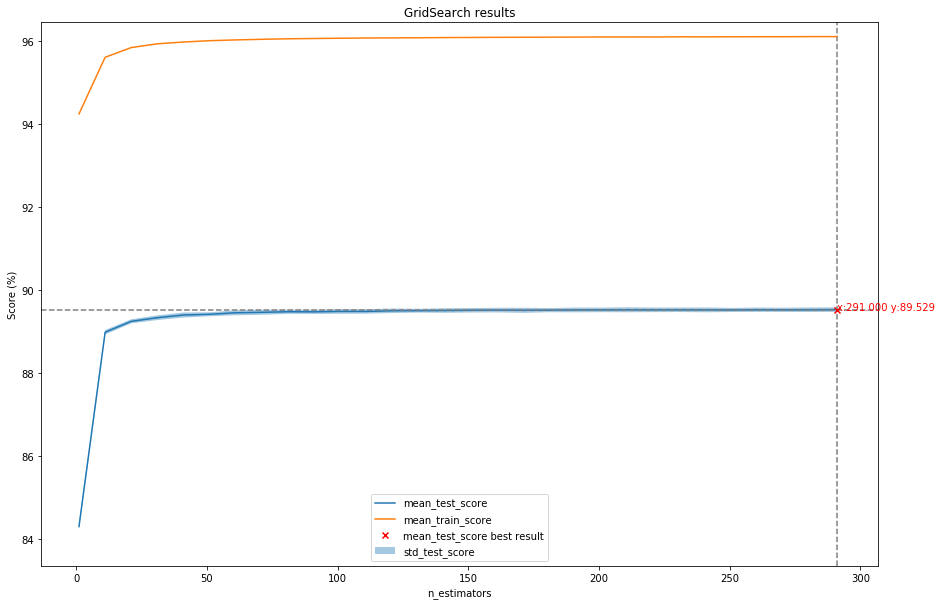

In [7]:
# Parameter name to plot
MODEL_PARAM='n_estimators'

# Plot train and validation curve
results_df=grid_df.sort_values(f'param_model__{MODEL_PARAM}')

plot_grid_search_results(results_df, x_param=f'param_model__{MODEL_PARAM}', semilogx=False, xlabel=MODEL_PARAM)

## Prediction

Now that we've found the best parameters and get the best estimator via *GridSearchCV()*, let's calculate the prediction score of this model.

In [8]:
# Get best estimator from grid search and predict using X_va
y_pred=grid_search.predict(X_va)

# Get the MAE and MAPE from y_pred
print("RandomForestRegressor model mean absolute error         : {:.3f} km/h".format(mae(y_pred, y_va)))
print("RandomForestRegressor model mean absolute percent error : {:.2f} %".format(mape(y_pred, y_va)))




RandomForestRegressor model mean absolute error         : 1.296 km/h
RandomForestRegressor model mean absolute percent error : 89.40 %


## Save model


In [9]:
save_model(grid_search, 'random-forest')

Saving model random-forest to ./data/model-random-forest.sav using 'pickle' library


# Explore and graph the *RandomForestRegressor* model trained

Models trained during grid search process are stored in *Pipeline* objects stored in *GridSearchCV* one.

The best trained *RandomForestRegressor* object can be grabbed from the *Pipeline* object retrieved from *GridSearchCV* using its *best_estimator_* property.

As the *Pipeline* returned contains only one step (the model to train), I can get the best *RandomForestRegressor* trained model using the following syntax:


In [10]:
# Get best estimator Pipeline from GridSearchCV
pipeline=grid_search.best_estimator_

# Get RandomForestRegressor trained model
rf=pipeline.named_steps['model']

print("Number of estimators in the best model trained:", len(rf.estimators_))



Number of estimators in the best model trained: 291


As expected, the number of estimators matches the choice made by the grid search.

## Visualizing the Decision Tree

### Display Decision Tree as a picture

Using the *export_graphviz()* method, I will obtain a graphical representation of the Decision Tree for one of the estimators of the *RandomForestRegressor* model trained before.

> Note 1: By default, I use the first estimator of the model (*model.estimators_[0]*)

> Note 2: I will limit the tree display to a max depth of 7, due to computation limit.


In [11]:
def draw_estimator(estimator, max_depth=None, resize=[1200,600]) -> Image.Image :
    """
    Function used to draw a graphical representation of a RandomForestRegresor estimator.
    
    Returns:
    --------
    An PIL.Image object representing the graph
    
    """
    
    # Define the name of the temporary PNG file created
    png_filename='random-forest-tree'

    # Load feature list
    _, feature_list, *_ = load_dataset(verbose=False)

    # USe Source class to create the PNG file
    graph=Source( export_graphviz(estimator, out_file=None, max_depth=max_depth, feature_names=feature_list, rounded=True), format='png', directory=IMG_PATH, filename=png_filename)
    graph.render(png_filename,view=False)

    # Return PIL.Image from the PNG file created before
    return Image.open(os.path.join(IMG_PATH, png_filename+'.png')).resize(resize, Image.ANTIALIAS)


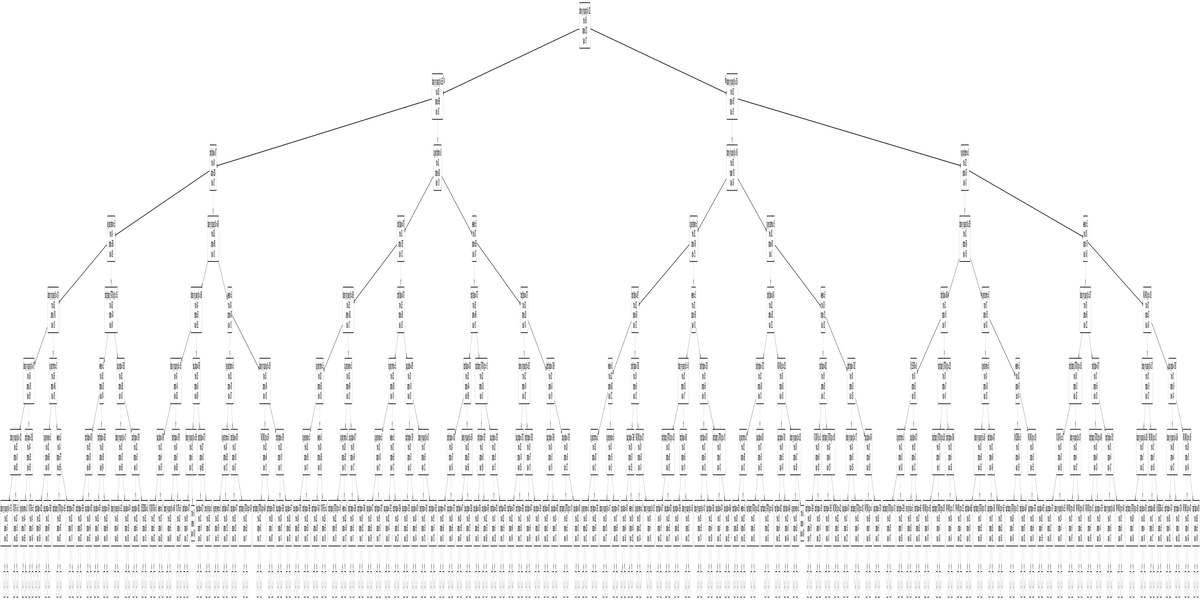

In [12]:
# Draw estimator with depth 7
draw_estimator(rf.estimators_[0], max_depth=7)

Of course, the previous graph is not really usable, as it is a quite huge graph that I was forced to resize.

### Limit to the first three levels

Display again this Decision Tree but using a *max_depth* value of 3 to see how the model *classify* datasets entries to preduct results.


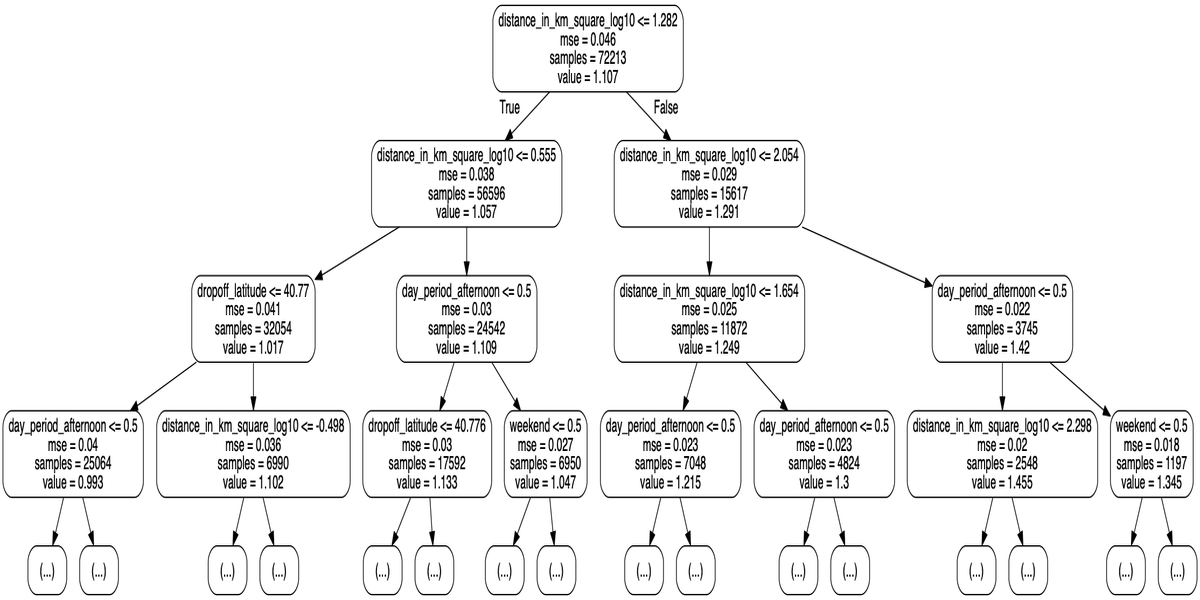

In [13]:
# Draw estimator with max_depth=3
draw_estimator(rf.estimators_[0], max_depth=3)

That's more clear, now we can see on this graph how the features and their values are used to predict results.

But wait, is there some features that are more important in terms of prediction ?

## Top most relevant features

The *RandomForestRegressor* model expose a property named *feature_importances_* which give, for each feature, their relative importance in the Decision Tree. Looking at this property, we can identify which features are the most important one to predict result.

To show this importance par feature in a smart manner, I'll draw a bar graph with features on X-axis and importance on Y-axis, the most important feature being on the left side of the X-axis.

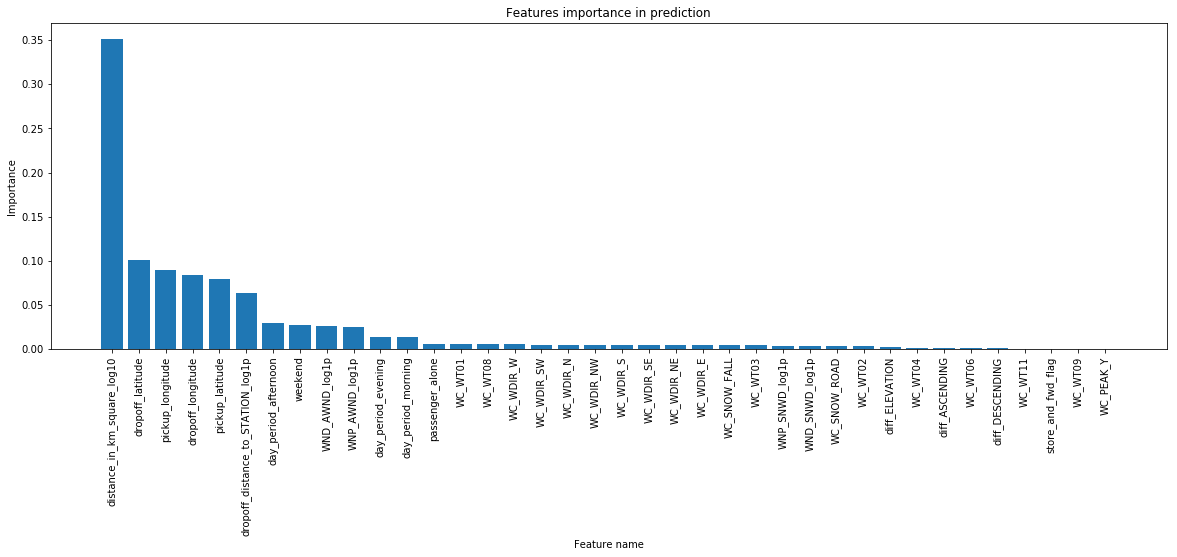

In [14]:
# Load feature name list
_, feature_list, *_ = load_dataset(verbose=False)

# Get feature importances
importances = rf.feature_importances_

# Map feature list name with feature importance in a dict
#feature_importances = [(feature, importance) for feature, importance in zip(feature_list, importances)]

feature_importances = { feature: importance for feature, importance in zip(feature_list, importances)}
feature_importances={k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)}

plt.figure(figsize=(20,6))

# Calculate x_values range (trick to use when X-axis is made of strings)
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, list(feature_importances.values()))

# Tick labels for x axis, replacing range values
plt.xticks(x_values, feature_importances.keys(), rotation='vertical')

# Axis labels and title
plt.ylabel('Importance')
plt.xlabel('Feature name')
plt.title('Features importance in prediction')
plt.show()





Interesting results, the top most important feature is the distance in km of the Taxi trip, followed by the pickup and dropoff location, and the dropoff distance to the nearest weather station.

A good demonstration of how it has been usefull to engineer new features from the original one :-)


# Time to go to the next model

A Neural Network one, the [MLPRegressor](34.Neural%20Network%20-%20MLPRegressor.ipynb)